In [1]:
import pandas as pd

In [2]:
DATA_PATH = "../data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

In [3]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [4]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [5]:
label_1 = "TotalGHGEmissions"
label_2 = "SiteEnergyUse(kBtu)"

In [6]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [7]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [8]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [9]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [10]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State","Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber","YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus", "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [11]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [13]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [14]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

In [15]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

In [16]:
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)
numerical_columns = update_columns_list(numerical_columns,columns_to_drop)

In [17]:
df = data[features]
cat_features = [col for col in features if col in categorical_columns]
num_features = [col for col in features if col in categorical_columns]

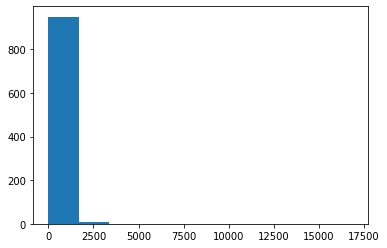

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df["TotalGHGEmissions"]);

In [19]:
df["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [20]:
df["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [21]:
df = df[df["TotalGHGEmissions"] <= df["TotalGHGEmissions"].quantile([0.98])[0.98]]
df = df[df["TotalGHGEmissions"] > 0]

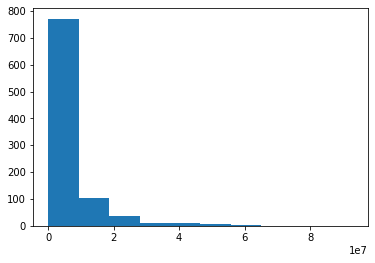

In [22]:
plt.hist(df[label_2]);

In [23]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [24]:
# encoding ZipCode with mean encoding and TotalGHGEmissions #
# Calculer la moyenne de la colonne cible (label2) pour chaque code postal
means = df.groupby('ZipCode')['TotalGHGEmissions'].mean()

# Encoder la colonne code postal en fonction de la moyenne de la colonne cible
df['code_postal_encoded'] = df['ZipCode'].map(means)

# Supprimer la colonne catégorielle
df.drop(columns=['ZipCode'],inplace=True)

In [25]:
onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')

# Ajouter les colonnes encodées au dataframe d'origine
df = pd.concat([df, onehot_encoded], axis=1)

# Supprimer la colonne originale
df.drop('LargestPropertyUseType', axis=1, inplace=True)

In [26]:
# Liste des colonnes à remplacer
cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)

# Boucle pour remplacer les valeurs dans chaque colonne
for col in cols_to_replace:
    df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)
    
df.drop(columns=["%_LargestPropertyUseType"], inplace=True)

In [27]:
# encoding Neighborhood de manière encodale #
# compter le nombre d'occurrences de chaque catégorie
freq = df['Neighborhood'].value_counts()

# remplacer les catégories par leur fréquence
df['Neighborhood_freq'] = df['Neighborhood'].map(freq)

# Supprimer la colonne catégorielle
df.drop(columns=['Neighborhood'],inplace=True)

In [28]:
onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')

# Ajouter les colonnes encodées au dataframe d'origine
df = pd.concat([df, onehot_encoded_BuildingType], axis=1)

# Supprimer la colonne originale
df.drop('BuildingType', axis=1, inplace=True)

In [29]:
# encoding PrimaryPropertyType with mean encoding and TotalGHGEmissions #
# Calculer la moyenne de la colonne cible (label2) pour chaque code postal
means = df.groupby('PrimaryPropertyType')['TotalGHGEmissions'].mean()

# Encoder la colonne code postal en fonction de la moyenne de la colonne cible
df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means)

# Supprimer la colonne catégorielle
df.drop(columns=['PrimaryPropertyType'],inplace=True)

In [30]:
df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)

In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[label_1,label_2])
y1 = df[[label_1]]
y2 = df[[label_2]]

X_train, X_test, y1_train, y1_test = train_test_split(X,y1, test_size=0.2, random_state=42)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean", "median", "quantile"), 
              "quantile": [0.25, 0.5, 0.75]}
grid_dummy = GridSearchCV(dummy_regr, 
                          param_grid=parameters,
                          cv=5,
                          n_jobs=-1, 
                          scoring="r2")
grid_dummy.fit(X, y1)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'quantile': [0.25, 0.5, 0.75],
                         'strategy': ('mean', 'median', 'quantile')},
             scoring='r2')

In [43]:
# Best score
grid_dummy.best_score_

# Best Params
grid_dummy.best_params_

# Best estimator
grid_dummy.best_estimator_

DummyRegressor(quantile=0.25, strategy='median')